# 1. Importing Libraries and Data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import random

In [23]:
df = pd.read_csv('Hotel_Income_Final.csv', sep=';')
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,January 2023,65364,NaN
1,December 2022,74247,NaN
2,November 2022,104789,NaN
3,October 2022,143499,NaN
4,September 2022,150165,NaN


# 2. Preprocessing and cleaning

In [24]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  205 non-null    object 
 1   Unnamed: 1  205 non-null    int64  
 2   Unnamed: 2  0 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.9+ KB


,Unnamed: 1,Unnamed: 2
count,205.000000,0.0
mean,57166.112195,NaN
std,29151.630802,NaN
min,1160.000000,NaN
25%,37377.000000,NaN
50%,53197.000000,NaN
75%,70566.000000,NaN
max,150165.000000,NaN


In [25]:
df = df.drop(['Unnamed: 2'], axis=1)

In [26]:
# Rename columns and convert date to datetime
df.columns = ['Month', 'Income']
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(by='Month', ascending=True)

# Set index to date 
df = df.set_index('Month')

In [27]:
df.head()

,Income
Month,
2006-01-01,25938
2006-02-01,27190
2006-03-01,35988
2006-04-01,45247
2006-05-01,55714


# 3. Visualize and decompose data 

Text(0.5, 1.0, 'Hotel Income')

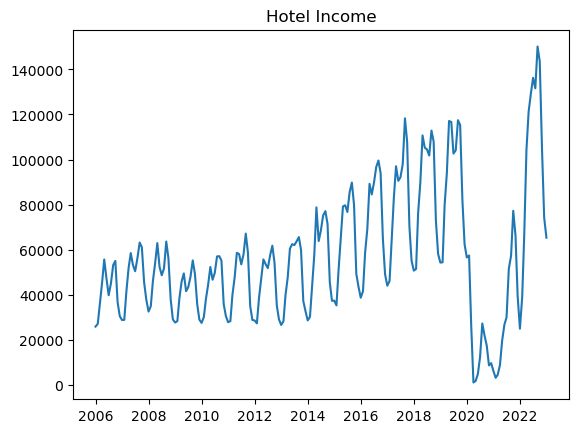

In [28]:
plot1 = plt.plot(df)
plt.title('Hotel Income')

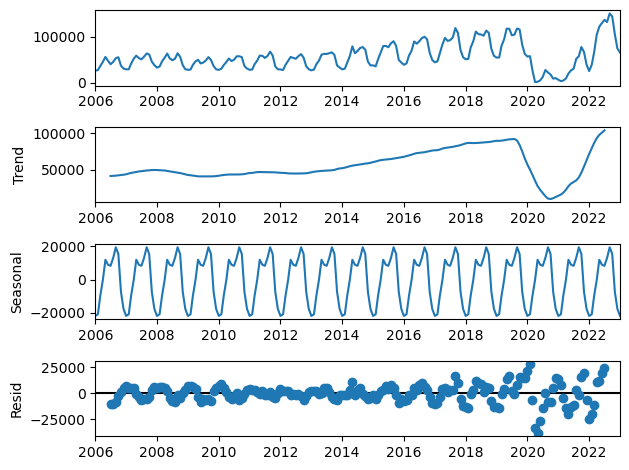

In [29]:
# Decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, model='additive')
fig = decomposition.plot()

plt.show()

# 4. Check for stationarity

This will help us decide our d-terms on our SARIMA model

In [30]:
from statsmodels.tsa.stattools import adfuller

# Dickey–Fuller test:
result = adfuller(df['Income'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

ADF Statistic: -3.4978903817013864
p-value: 0.00804143911080711
Critical Values:
	1%: -3.4652439354133255
	5%: -2.8768752281673717
	10%: -2.574944653739612


Our data is stationary so we will not need to difference it (d = 0, D = 0).

# 5. Plot ACF and PACF

/Users/lukegorman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


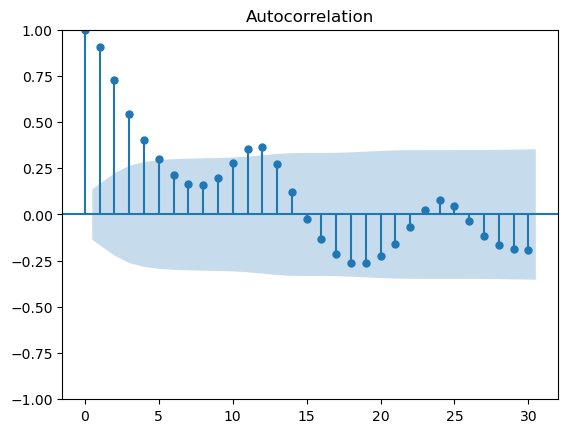

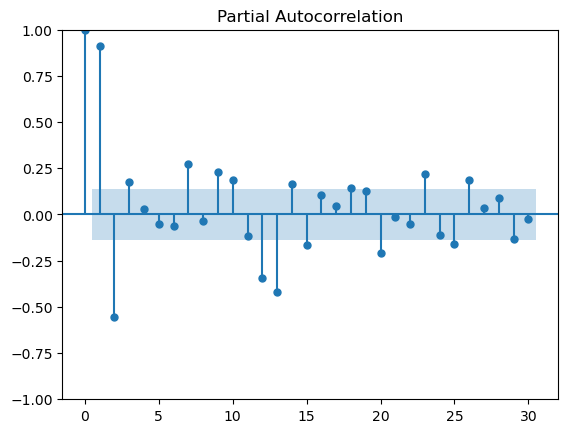

In [31]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(df['Income'],lags=30);
plot_pacf(df['Income'],lags=30);

# 7. Fitting model and Diagnostics

Trying on training set first. It is common place in forecasting test/train splits to use 85% to train and not at random. So the first 85% must be used

In [ ]:
import warnings
warnings.filterwarnings("ignore")
train = df['Income'][:174] # first 85% of data 
test = df['Income'][31:] # last 15% of data

In [33]:
#Import auto_arima function
from pmdarima import auto_arima
train_model = auto_arima(train, start_p=0, start_q=0,
    test='adf',
    ax_p=3, max_q=3, m=12,
    seasonal=True,
    d=None, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)
train_model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=3948.874, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4015.808, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3759.123, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4336.948, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3838.148, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3874.720, Time=0.13 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3735.848, Time=0.72 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=3872.719, Time=0.69 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=3937.580, Time=0.12 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=3634.682, Time=0.18 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3651.964, Time=0.07 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=3630.117, Time=0.97 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=3630.850, Time=0.25 sec
 ARIMA(1,0,1)(2,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  174
Model:             SARIMAX(1, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -1788.976
Date:                            Tue, 18 Apr 2023   AIC                           3591.953
Time:                                    16:47:30   BIC                           3614.066
Sample:                                01-01-2006   HQIC                          3600.923
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6498.7412   1720.300      3.778      0.000    3127.015    9870.467
ar.L1          0.8414      0.036     23.160      0.000       0.770       0.913
ma.L1          0.4265      0.047      9.100      0.000       0.335       0.518
ar.S.L12      -0.2055      0.157     -1.309      0.190      -0.513       0.102
ar.S.L24       0.7146      0.147      4.846      0.000       0.426       1.004
ma.S.L12       0.8822      0.261      3.386      0.001       0.372       1.393
sigma2      4.347e+07      0.467   9.32e+07      0.000    4.35e+07    4.35e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):              2106.50
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               5.95   Skew:                            -2.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.79e+23. Standard errors may be unstable.
"""

In [61]:
import statsmodels.api as smapi
ari_train_model = smapi.tsa.arima.ARIMA(train, order=(1, 0, 1), seasonal_order=(2, 0, 1, 12)) #Best training model according to auto_arima
fitted = ari_train_model.fit()

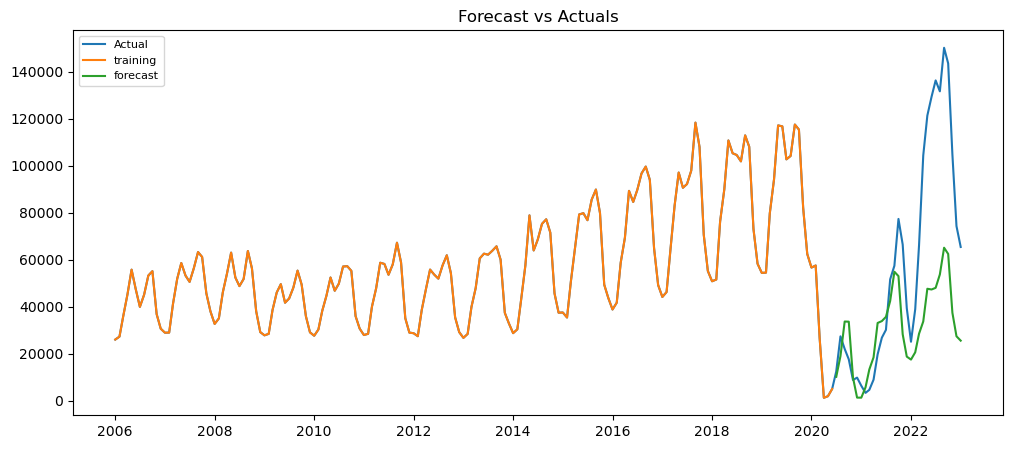

In [62]:
fc = fitted.forecast(31, alpha = 0.05)
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Income'], label = 'Actual')
plt.plot(train, label='training')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Get the predicted values from the training model. We will compare this to the actual values

In [36]:
from statsmodels.graphics.tsaplots import plot_predict
y_pred = fitted.forecast(31).values
y_pred

array([10081.2765527 , 18910.59042426, 33625.074997  , 33559.19630525,
        9752.71761474,  1231.46746513,  1208.41660761,  5602.49527417,
       13228.2527914 , 18369.9094524 , 33012.12009733, 33812.83035695,
       35607.15131283, 42369.01398827, 54828.01229055, 52947.32137134,
       28196.31783441, 18684.35344254, 17419.45622675, 20514.90130531,
       28422.4198674 , 33645.30181629, 47572.06152773, 47262.46708572,
       47960.94323585, 53671.7245156 , 65041.87002931, 62392.95625401,
       37351.47564837, 27343.17296273, 25480.35568745])

In [37]:
y_true =df['Income'][:31].values

In [38]:
#Convert y_true and y_pred to np.array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [41]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

mape_ARIMA = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:",round(mape_ARIMA,4))
print("MAE:", round(mean_squared_error(y_true, y_pred, squared=False),4))

MAPE: 0.4594
MAE: 25718.3254


- The MAPE is poor(45%), we suspect this is due to covid-19 and its effect on the model. 
- We will still build a SARIMA model and see how it forecasts

# 8. Forecast next 24 months

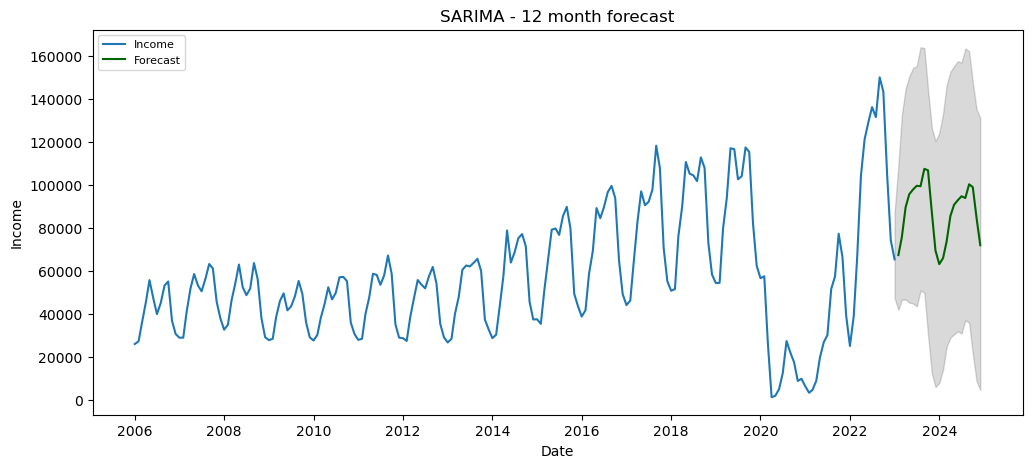

In [83]:
n_periods = 24
fit, confint = best_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fit, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Income'], label='Income')
plt.plot(fitted_series, color='darkgreen', label='Forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("SARIMA - 12 month forecast")
plt.xlabel('Date')
plt.ylabel('Income')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Get the predicted forecast values in a dataframe
df_forecast = pd.DataFrame(fitted, columns=['Forecast'])
df_forecast['Month'] = index_of_fc
df_forecast = df_forecast.set_index('Month')
df_forecast.tail()


,Forecast
Month,
2024-08-01,100331.331280
2024-09-01,99010.695160
2024-10-01,84575.222804
2024-11-01,71948.041700
2024-12-01,67793.771629


Forecast vlaue for 2024 according to ARIMA:

In [ ]:
df_forecast.tail(12).sum()

Forecast    1.021258e+06
dtype: float64

Forecast value for 2023 according to ARIMA:

In [ ]:
df_forecast.head(12).sum()

Forecast    1.059821e+06
dtype: float64

[Text(0, 0, 'Feb 2023'),
 Text(1, 0, 'Mar 2023'),
 Text(2, 0, 'Apr 2023'),
 Text(3, 0, 'May 2023'),
 Text(4, 0, 'Jun 2023'),
 Text(5, 0, 'Jul 2023'),
 Text(6, 0, 'Aug 2023'),
 Text(7, 0, 'Sep 2023'),
 Text(8, 0, 'Oct 2023'),
 Text(9, 0, 'Nov 2023'),
 Text(10, 0, 'Dec 2023'),
 Text(11, 0, 'Jan 2024'),
 Text(12, 0, 'Feb 2024'),
 Text(13, 0, 'Mar 2024'),
 Text(14, 0, 'Apr 2024'),
 Text(15, 0, 'May 2024'),
 Text(16, 0, 'Jun 2024'),
 Text(17, 0, 'Jul 2024'),
 Text(18, 0, 'Aug 2024'),
 Text(19, 0, 'Sep 2024'),
 Text(20, 0, 'Oct 2024'),
 Text(21, 0, 'Nov 2024'),
 Text(22, 0, 'Dec 2024')]

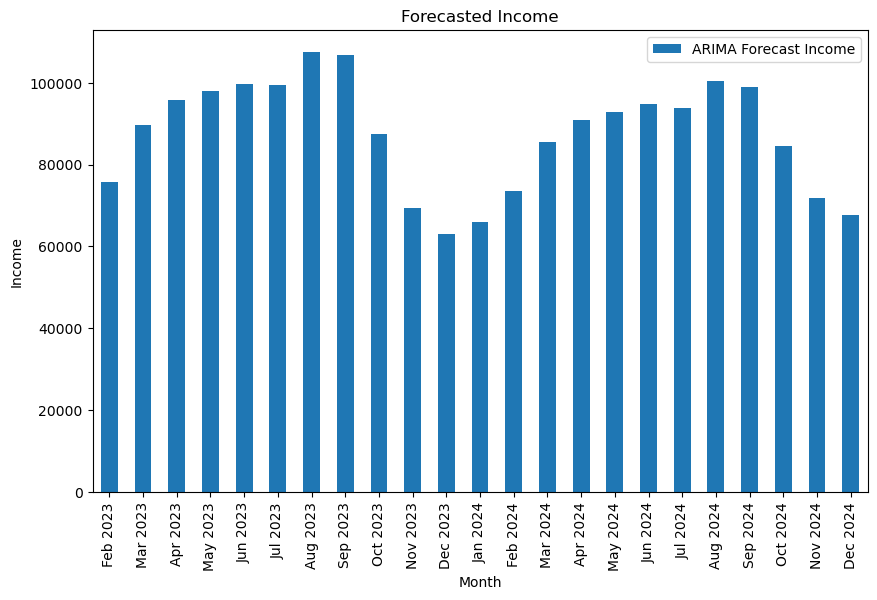

In [ ]:
#Plot a bar chart of the final 24 values
Bar = df_forecast.tail(23).plot(kind='bar', figsize=(10,6))
Bar.set_title('Forecasted Income')
Bar.set_xlabel('Month')
Bar.set_ylabel('Income')
Bar.legend(['ARIMA Forecast Income'])
Bar.set_xticklabels(df_forecast.tail(23).index.strftime('%b %Y'))


# 9. Trying a new model because ARIMA struggles with coivd impact and MAPE is 46% 

In [85]:
pro_df = pd.read_csv('Hotel_Income_Final.csv', sep=';')
pro_df = pro_df.drop(['Unnamed: 2'], axis=1)

# Rename columns and convert date to datetime
pro_df.columns = ['ds', 'y']
pro_df['ds'] = pd.to_datetime(pro_df['ds'])
pro_df = pro_df.sort_values(by='ds', ascending=False)


In [86]:
pro_df.tail()

,ds,y
200,2006-05-01,55714
201,2006-04-01,45247
202,2006-03-01,35988
203,2006-02-01,27190
204,2006-01-01,25938


# 10. Build and fit prophet model + remove lockdowns

The prophet model allows us to remove unpredicted events such as the coivd pandemic by adding holidays to the model. The model then predicts the data without the holiday. 

In [87]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'lockdown_5', 'ds': '2021-06-13', 'lower_window': 0, 'ds_upper': '2021-06-27'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13
4,lockdown_5,2021-06-13,0,2021-06-27,14


Train / test split

In [88]:
train_pro = pro_df[:174] # first 85% of data
test_pro = pro_df[:31] # last 15% of data
train_pro.shape, test_pro.shape

((174, 2), (31, 2))

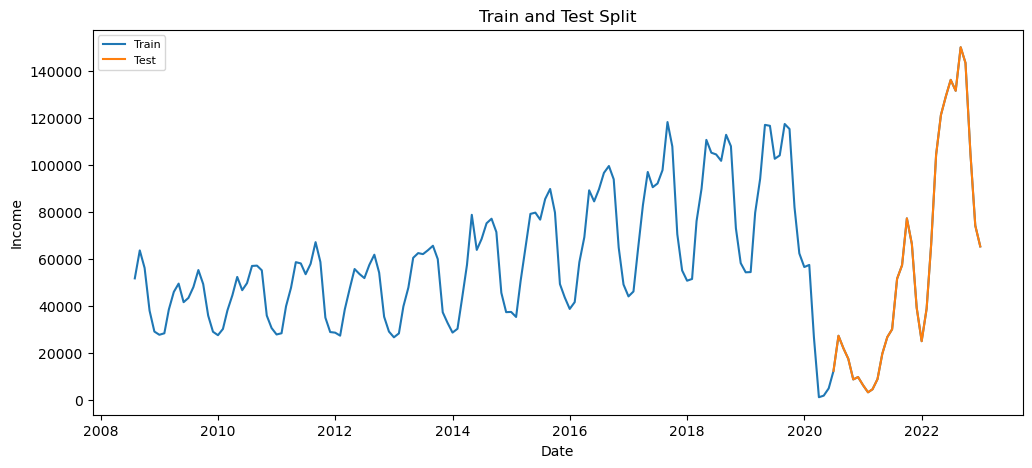

In [90]:
#Plot test and train to visualise the split
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_pro['ds'], train_pro['y'], label='Train')
plt.plot(test_pro['ds'], test_pro['y'], label='Test')
plt.title("Train and Test Split")
plt.xlabel('Date')
plt.ylabel('Income')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [92]:
# Build a basic model
m = Prophet()
add_seasonality = m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(train_pro)


17:28:24 - cmdstanpy - INFO - Chain [1] start processing
17:28:24 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
# Fit the model to the data and forecast
future = m.make_future_dataframe(periods=24, freq='MS')
forecast_fut = m.predict(future)
forecast_fut[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
191,2024-07-01,127107.530808,104329.920128,152688.956516
192,2024-08-01,135502.908709,111837.813586,160032.866490
193,2024-09-01,120069.312862,95928.782729,144831.736308
194,2024-10-01,129327.480556,103519.792447,155713.449376
195,2024-11-01,92896.934771,66061.475745,118206.605681
196,2024-12-01,98393.618169,73894.112864,122263.071105
197,2025-01-01,76061.271674,52216.651717,98420.019852


In [94]:
X_tst_forecast = m.predict(test_pro)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
24,2022-07-01,120100.054593,96719.687641,144557.943895
25,2022-08-01,106988.037338,83014.286950,131436.462703
26,2022-09-01,98480.453094,73410.191884,122988.395250
27,2022-10-01,113357.107844,88368.941197,135609.181304
28,2022-11-01,68927.276244,43994.058368,93856.815467
29,2022-12-01,75360.168597,51411.409423,99981.579049
30,2023-01-01,53781.413397,29869.730614,79909.682153


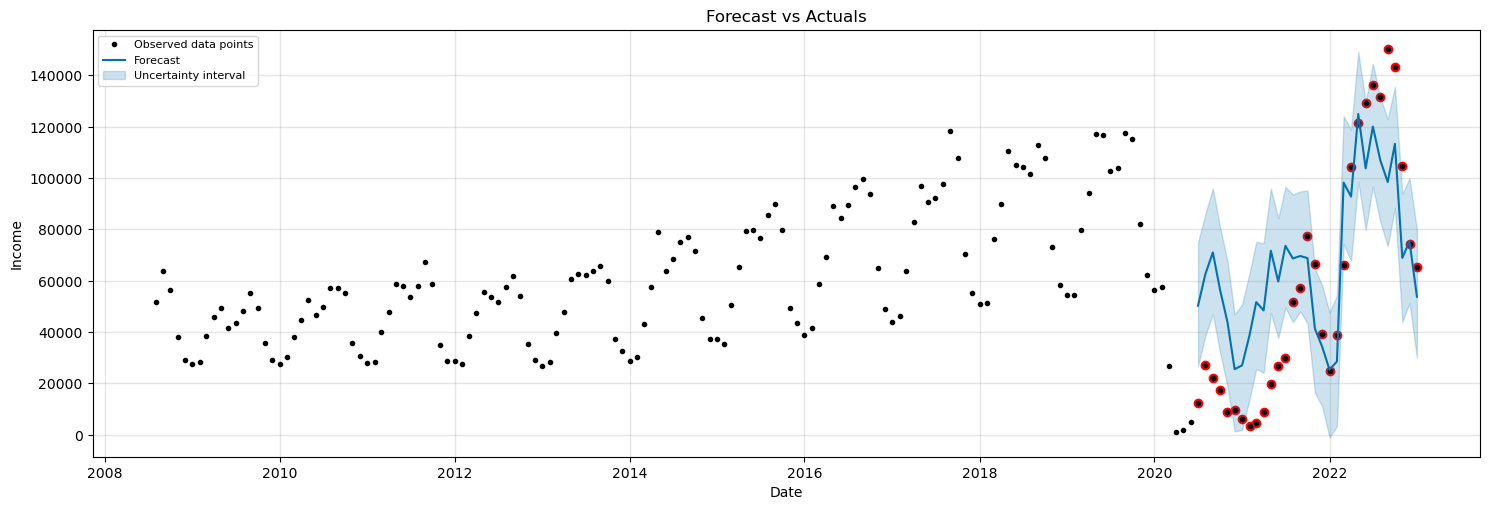

In [96]:
#Plottig the forecast vs the actuals

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test_pro.ds, test_pro['y'], color='r')
fig = m.plot(X_tst_forecast, ax=ax)
plt.title("Forecast vs Actuals")
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Date')
plt.ylabel('Income')
plt.show()

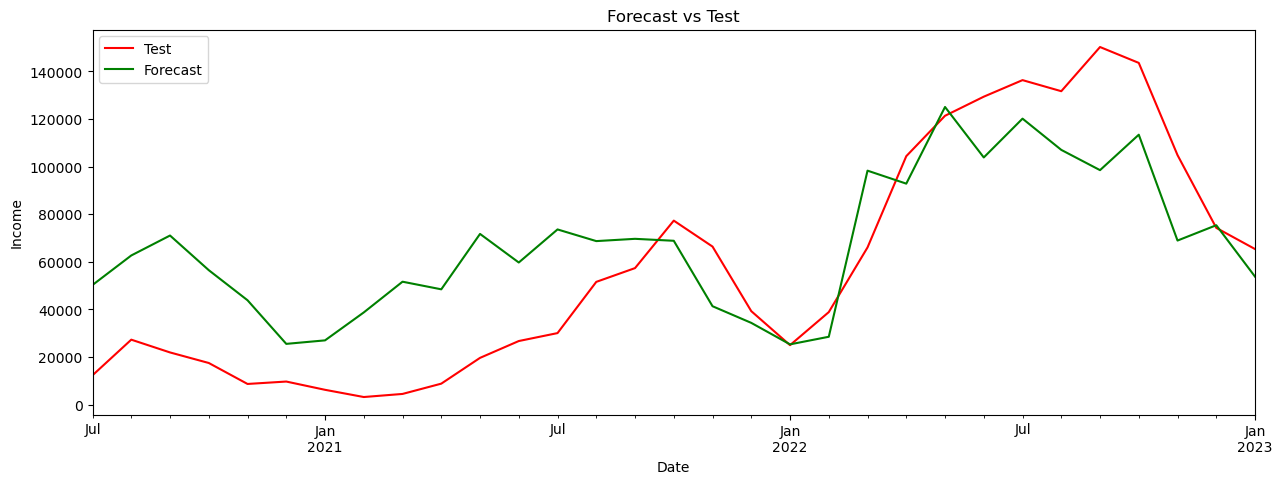

In [97]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test_pro.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Test')
plt.xlabel('Date')
plt.ylabel('Income') 
plt.show()

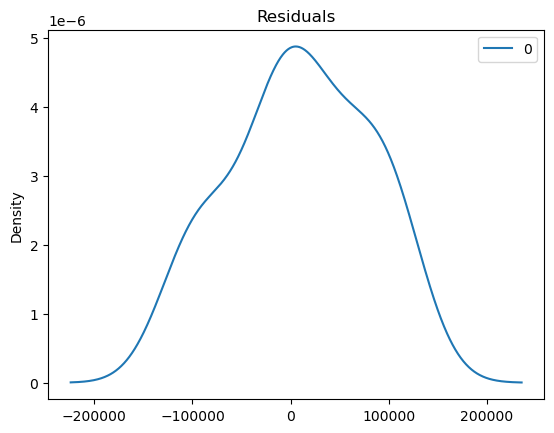

In [99]:
#plot residuals to check for normality
residuals = pd.DataFrame(X_tst_forecast['yhat'] - test_pro['y'])
residuals.plot(kind='kde')
plt.title('Residual Plot') 
plt.show()

In [100]:
mape = mean_absolute_percentage_error(test_pro['y'],X_tst_forecast['yhat'])
print("MAPE", mape)

MAPE 4.251871546494271


- The MAPE is high and the model is not very accurate (42%)
- We need to optimize the model by tuning the hyperparameters and add the lockdowns as holidays

# 11. Hyperparameter tuning

In [101]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [114]:
strt='2016-01-01'
end='2020-01-01'
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality= False,
                         
                         daily_seasonality = False,
                         yearly_seasonality = False,
                         holidays=lockdowns, 
                         interval_width=0.95)
    train_model.fit(train_pro)
    train_forecast = train_model.make_future_dataframe(periods=48, freq='MS',include_history = False)

    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = pro_df[(pro_df['ds']>strt) & (pro_df['ds']<=end)]

    MAPE = mean_absolute_percentage_error(Actual['y'], abs(test['yhat']))

    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:35:48 - cmdstanpy - INFO - Chain [1] start processing
17:35:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28320203341700906
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:35:49 - cmdstanpy - INFO - Chain [1] start processing
17:35:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28613409393792116
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:35:49 - cmdstanpy - INFO - Chain [1] start processing
17:35:49 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2817589059940595
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:35:50 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2845033825852725
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:35:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2817589059940595
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:50 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2845033825852725
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:35:50 - cmdstanpy - INFO - Chain [1] done processing
17:35:51 - cmdstanpy - INFO - Chain [1] start processing
17:35:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2814174547987456
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:35:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2840058371432797
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:35:51 - cmdstanpy - INFO - Chain [1] done processing
17:35:51 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28085411573982655
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2851833777129072
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:35:52 - cmdstanpy - INFO - Chain [1] done processing
17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28085411573982655
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2851833777129072
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:35:53 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28401935744676843
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:35:53 - cmdstanpy - INFO - Chain [1] done processing
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2840186127798481
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:35:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2822549008477228
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:54 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28269320580579843
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2822549008477228
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:35:55 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28269320580579843
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:55 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28607455617898775
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:35:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2851988217495291
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:35:56 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:56 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2873782953045414
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:35:56 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28501128716268526
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:35:57 - cmdstanpy - INFO - Chain [1] done processing
17:35:57 - cmdstanpy - INFO - Chain [1] start processing
17:35:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2873782953045414
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:35:57 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28501128716268526
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:35:57 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.287192010561199
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:35:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2870392770072669
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:58 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.29007387317207717
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:35:59 - cmdstanpy - INFO - Chain [1] done processing
17:35:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28607148311993585
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:35:59 - cmdstanpy - INFO - Chain [1] done processing
17:35:59 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.29007387317207717
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:35:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28607148311993585
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27994514440947466
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:00 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2784374335759899
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27936571952232164
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:01 - cmdstanpy - INFO - Chain [1] done processing
17:36:01 - cmdstanpy - INFO - Chain [1] start processing
17:36:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2778462761502291
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:01 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27936571952232164
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:01 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2778462761502291
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:02 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27703940327668164
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:02 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.276700279595315
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:03 - cmdstanpy - INFO - Chain [1] done processing
17:36:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2770278457707413
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:03 - cmdstanpy - INFO - Chain [1] done processing
17:36:03 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27684233630720545
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:03 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2770278457707413
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27684233630720545
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27702079113061706
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:05 - cmdstanpy - INFO - Chain [1] done processing
17:36:05 - cmdstanpy - INFO - Chain [1] start processing
17:36:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2777317990516186
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:05 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27696137863993225
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:05 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.277777048606712
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27696137863993225
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:06 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.277777048606712
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2764435942045626
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2784686079568348
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27646905963361634
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2777419006381399
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27646905963361634
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2777419006381399
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:09 - cmdstanpy - INFO - Chain [1] done processing
17:36:09 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27686770664441757
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27822252084434934
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:10 - cmdstanpy - INFO - Chain [1] done processing
17:36:10 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27766420003751685
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2783016519685741
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:11 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27766420003751685
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:11 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2783016519685741
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:12 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28011132518286425
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27856714414656475
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2798901231768421
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27956830101412694
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2798901231768421
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27956830101412694
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:14 - cmdstanpy - INFO - Chain [1] done processing
17:36:14 - cmdstanpy - INFO - Chain [1] start processing
17:36:15 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.277827760981523
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2769263838286921
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:15 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27839813961486953
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:15 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2768835603831838
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:16 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27839813961486953
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:16 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2768835603831838
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27829343376407706
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2768521838163464
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2775500971336991
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:18 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27667077706009474
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:18 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2775500971336991
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27667077706009474
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:19 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28005445441664795
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:19 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2766916759857965
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:20 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27785927929897153
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2767171157612135
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27785927929897153
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2767171157612135
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28380631637775106
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2764373627407057
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:22 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2781708039178609
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27681144566544064
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:23 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2781708039178609
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:23 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:23 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27681144566544064
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.3555638048684999
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.30253452838551204
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2965270268287615
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2984365183426165
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:25 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2965270268287615
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2984365183426165
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.29360785970178527
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:26 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2886823278447997
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2890070835119051
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2881863494457286
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2890070835119051
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2881863494457286
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:28 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2809691730719586
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2796322048926829
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28281066514181114
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:29 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2801388546092211
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:30 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.28281066514181114
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2801388546092211
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2825819843366219
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27880227753985676
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:31 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2850865350172225
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27885488825006405
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2850865350172225
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:32 - cmdstanpy - INFO - Chain [1] done processing
17:36:32 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27885488825006405
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2856272187299244
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:33 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2786844042056829
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:33 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2855310734633903
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27874668244042483
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:34 - cmdstanpy - INFO - Chain [1] done processing
17:36:34 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2855310734633903
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.27874668244042483
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:35 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5029627367578384
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:35 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.37514241474626103
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.36605562535756225
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.42298382601417533
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.36605562535756225
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.42298382601417533
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4177107962943027
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:38 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.34938254685491016
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:38 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.34923443717280395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.34930666384957193
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:39 - cmdstanpy - INFO - Chain [1] done processing
17:36:39 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.34923443717280395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.34930666384957193
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.38857974525897293
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.3586690905322958
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:41 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.3276440497294328
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:41 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.31901510098243885
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:42 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.3276440497294328
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:42 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.31901510098243885
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.30380496735557905
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:43 - cmdstanpy - INFO - Chain [1] done processing
17:36:43 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.32679580251803025
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:44 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.3111894093302809
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:44 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.33570537482017054
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:45 - cmdstanpy - INFO - Chain [1] done processing
17:36:45 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.3111894093302809
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.33570537482017054
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:46 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2945176055954539
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


17:36:46 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.30340435139593175
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:47 - cmdstanpy - INFO - Chain [1] start processing
17:36:47 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2978452755648712
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


17:36:47 - cmdstanpy - INFO - Chain [1] start processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.29320521962450524
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


17:36:47 - cmdstanpy - INFO - Chain [1] done processing
17:36:48 - cmdstanpy - INFO - Chain [1] start processing
17:36:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.2978452755648712
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.29320521962450524


In [115]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.276437,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."
1,0.276444,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
2,0.276469,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
3,0.276469,"{'changepoint_prior_scale': 0.2, 'holidays_pri..."
4,0.276671,"{'changepoint_prior_scale': 0.3, 'holidays_pri..."


Now we have optimal hyperparameters for our model, we can forcast the next 24 months.

# 11. Cross Validation on model 

In [116]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.3,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

In [103]:
optimal_model = Prophet(changepoint_prior_scale = 0.3, holidays_prior_scale = 0.15, n_changepoints = 100, seasonality_mode = 'additive', holidays=lockdowns, interval_width=0.95)
add_seasonality = optimal_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
optimal_model.fit(train_pro)

17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

#cutoffs = pd.to_datetime(['2020-01-01', '2019-01-01', '2016-01-01', '2010-01'])
df_cv = cross_validation(optimal_model, initial='1460 days', period='365 days', horizon = '365 days')

  0%|          | 0/10 [00:00<?, ?it/s]

17:32:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:17 - cmdstanpy - INFO - Chain [1] done processing
17:33:18 - cmdstanpy - INFO - Chain [1] start processing
17:33:26 - cmdstanpy - INFO - Chain [1] done processing
17:33:26 - cmdstanpy - INFO - Chain [1] start processing
17:33:38 - cmdstanpy - INFO - Chain [1] done processing
17:33:38 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:06 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing
17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing
17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1]

In [107]:
performance_df = perfomance_metrics = performance_metrics(df_cv)
performance_df

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,57 days,1.234660e+08,11111.523638,8097.615182,0.297037,0.155125,0.390799,0.583333
1,58 days,1.775025e+08,13323.007677,10528.483383,0.317889,0.171892,0.411052,0.437500
2,59 days,1.873810e+09,43287.529604,26398.763682,1.103584,0.272736,0.798922,0.250000
3,88 days,1.790211e+09,42310.881601,23857.696153,0.921905,0.157562,0.524744,0.250000
4,89 days,1.764625e+09,42007.443617,22886.510052,0.891723,0.093672,0.491866,0.416667
5,90 days,3.082144e+09,55517.062427,33302.625077,7.385878,0.116761,0.692975,0.416667
6,118 days,2.038919e+09,45154.393353,25878.507171,6.897076,0.155229,0.481634,0.388889
7,119 days,2.119750e+09,46040.745445,29349.334002,6.922238,0.197462,0.510053,0.208333
8,120 days,4.612683e+09,67916.738777,46221.259020,9.719886,0.305619,0.870349,0.055556
9,149 days,3.342178e+09,57811.570968,35444.223959,5.213052,0.197462,0.650236,0.083333


In [111]:
print("MAPE:", performance_df['mape'].mean())
print("MAE:",performance_df['mae'].mean())

MAPE: 2.172677593699313
MAE: 31443.43690381525


- Our model now has a mean MAPE of 21% which is much better than the ARIMA model.
- Moreover you can see from row 32 in the table that the MAPE for predicting 1 year out 16% which is good.

Text(0.5, 1.0, 'Cross Validation MAPE')

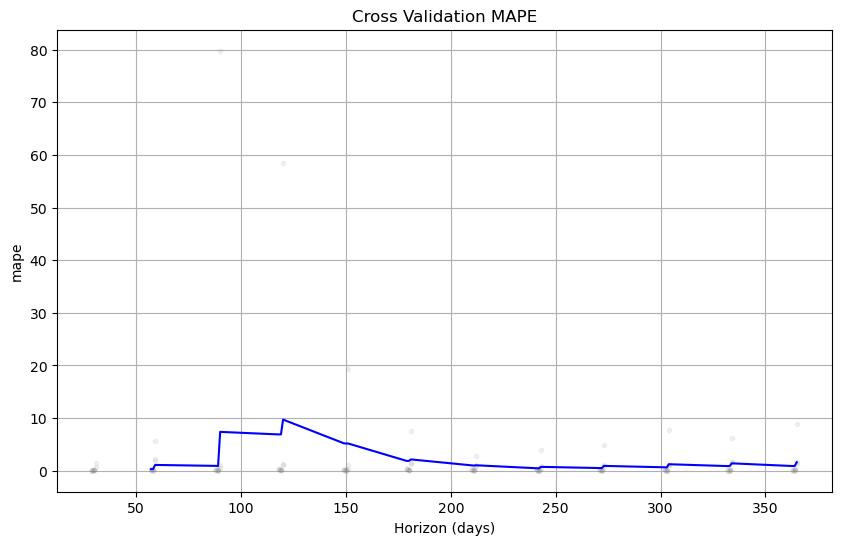

In [118]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
plt.title('Cross Validation MAPE')

- We are happy enough with this model so we will use it to predict the next 24 months on the main dataset.
- There are some limitations of course, we wish we had daily data.

# 12. Forecast to end of 2023

Text(53.722222222222214, 0.5, 'Income')

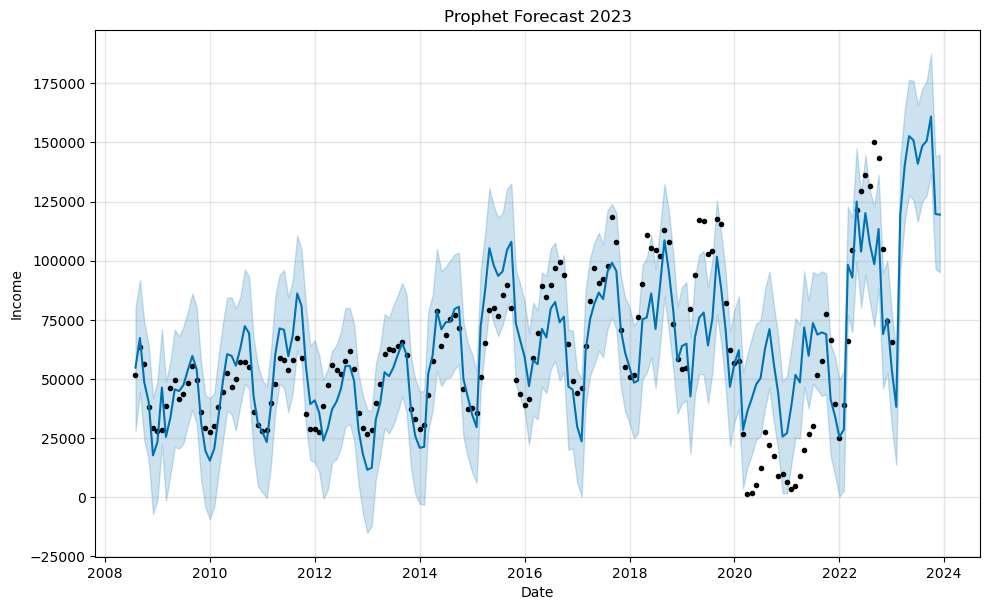

In [121]:
future23 = m.make_future_dataframe(periods=11, freq='MS')
final_forecast = m.predict(future23)
m_plot = m.plot(final_forecast)
plt.title('Prophet Forecast 2023')
plt.xlabel('Date')
plt.ylabel('Income')

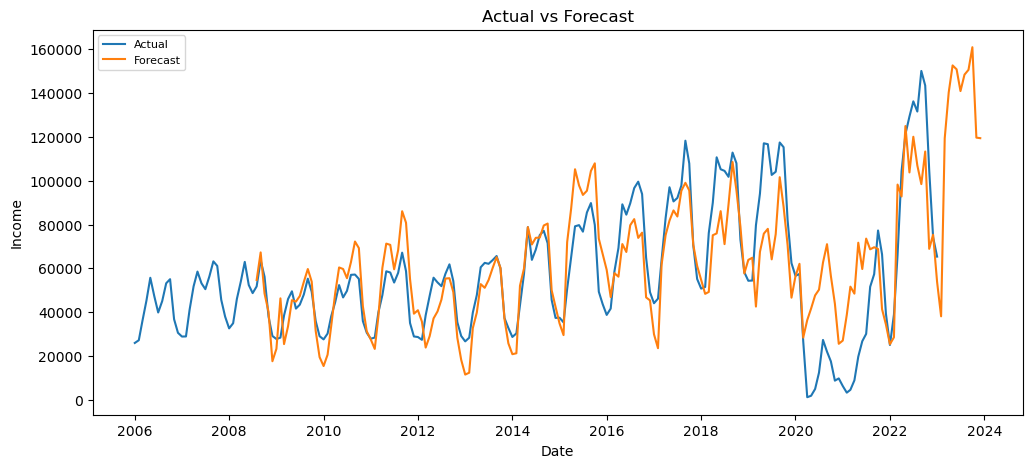

In [122]:
# plot the forecasted values against the actual values
plt.figure(figsize=(12,5), dpi=100)
plt.plot(pro_df['ds'], pro_df['y'], label='Actual')
plt.plot(final_forecast['ds'], final_forecast['yhat'], label='Forecast')
plt.title("Actual vs Forecast")
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Date')
plt.ylabel('Income')
plt.show()


In [ ]:
final_forecast[['ds', 'yhat']].tail(12)

,ds,yhat
173,2023-01-01,53781.413397
174,2023-02-01,38107.940535
175,2023-03-01,119386.799493
176,2023-04-01,140383.213780
177,2023-05-01,152684.724496
178,2023-06-01,150890.362163
179,2023-07-01,140954.586333
180,2023-08-01,148466.560694
181,2023-09-01,150668.175296
182,2023-10-01,160987.402220


# Forecast to 2024

Text(56.472222222222214, 0.5, 'Income')

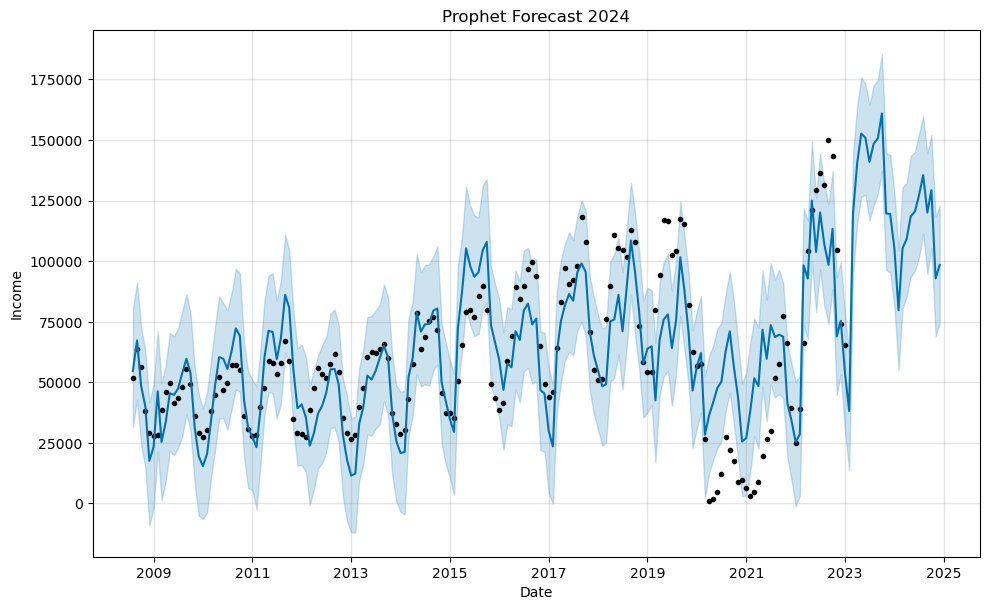

In [123]:
future24 = m.make_future_dataframe(periods=23, freq='MS')
final_forecast2 = m.predict(future24)
m_plot = m.plot(final_forecast2)
plt.title('Prophet Forecast 2024')
plt.xlabel('Date')
plt.ylabel('Income')


In [ ]:
final_forecast2[['ds', 'yhat']].tail(12)

,ds,yhat
185,2024-01-01,105450.570887
186,2024-02-01,79778.365590
187,2024-03-01,105218.154142
188,2024-04-01,109222.208409
189,2024-05-01,118514.059776
190,2024-06-01,120506.595342
191,2024-07-01,127107.530808
192,2024-08-01,135502.908709
193,2024-09-01,120069.312862
194,2024-10-01,129327.480556


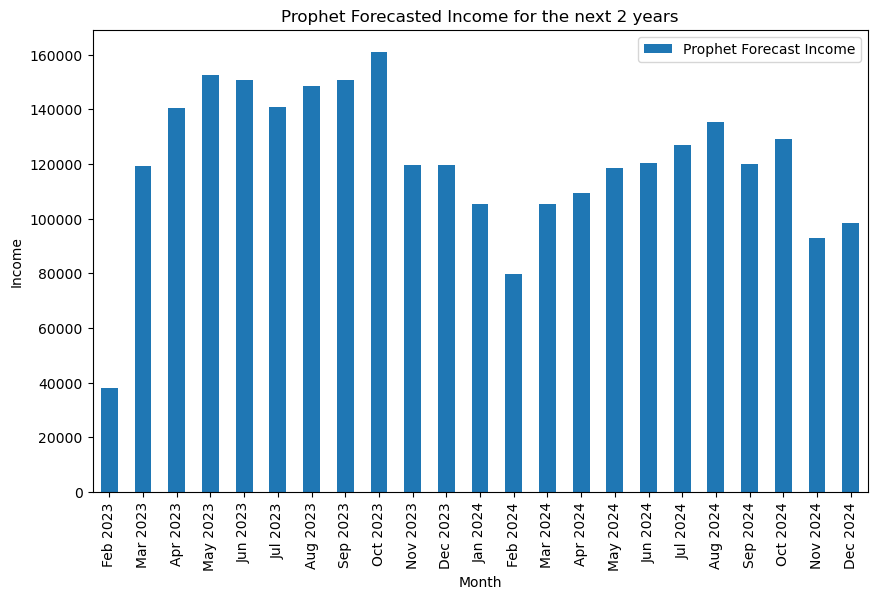

In [ ]:
#Plot the final forecast values on a bar chart for the last 24 months 
Bar = final_forecast2['yhat'].tail(23).plot(kind='bar', figsize=(10,6))
Bar.set_title('Prophet Forecasted Income for the next 2 years')
Bar.set_xlabel('Month')
Bar.set_ylabel('Income')
Bar.legend(['Prophet Forecast Income'])
Bar.set_xticklabels(final_forecast2['ds'].tail(23).dt.strftime('%b %Y'))
plt.show()

